In [1]:
%matplotlib inline
import numpy as np
from figures import feed_forward_replay_example as fig_1
from figures import feed_forward_replay_probability_calculation as fig_2

from IPython.display import HTML

### Sequence replay in a winner-take-all network with activation-dependent lingering hyperexcitability

We show in a simple model how changes in neural excitability can allow a network to replay sequences that have occurred in the recent past. Importantly, these changes are *nonassociative*, i.e., there are no explicit changes to the anatomical connections between ensembles.

#### The model

Our model consists of a collection of neural ensembles connected together into a network. Each ensemble can be in one of three states: active, inactive, or hyperexcitable. If an ensemble becomes active at one time step, on the next time step it transitions to the hyperexcitable state, where it remains for $T_x$ time steps, after which it returns to the inactive state in the absence of further activation. Thus, though activation may occur only for one time step, hyperexcitability "lingers" for a while afterwards.

Exactly one ensemble is allowed to be active per time step, that is, we suppose a winner-take-all (WTA) network. Which ensemble is active is chosen probabilistically in accordance with the total input the ensemble receives:

$$ P(i \textrm{ active at time } t) \propto e^{a_i(t)}.$$

Thus, the network explicitly calls the softmax function, though it is possible to implement this function through biophysical mechanisms including lateral inhibition (briefly, a dynamical system in which each ensemble inhibits all the others can quickly arrive at one of a number of fixed points, each corresponding to the activation of one ensemble). However, as long as each ensemble's activation probability increases monotonically with the strength of its inputs, the specific form of the distribution is not important for our results.

The vector input $\mathbf{a}$ to all the ensembles is given by:

$$ \mathbf{a}(t) = g_w W\mathbf{r}(t - 1) + g_x \mathbf{x}(t) + g_d \mathbf{d}(t), $$

where $W$ is the weight matrix, $\mathbf{r}(t - 1)$ is the activation vector at the last time step (which is equal to 1 for the ensemble that was active and 0 everywhere else), $\mathbf{x}$ is the vector of ensembles in the hyperexcitable state (1 for hyperexcitable ensembles, 0 for the others), and $\mathbf{d}$ is the external drive to the network. Thus, we represent hyperexcitability as increased input. The parameters $g_w$, $g_x$, and $g_d$ control the relative weighting, or gain, on each of the three types of inputs, indicated by their subscripts.

#### Network connectivity

We illustrate the basic consequences we expect from activation-dependent lingering hyperexcitability using a feed-forward network (not counting the implicit feed-back implied by the WTA rule) (**Drawing 1**). Later we generalize the network to different types of recurrent architectures. 

The feed-forward network we first explore consists of several layers (columns, visually), each containing the same number of ensembles. Each ensemble sends a strong excitatory projection ($w = 2$) to the ensemble immediately to the right of it (in the next layer), and weak excitatory projections ($w = 1$) to a number of ensembles immediately above and below the ensemble receiving the strong projection. That is, there is a small lateral spread as each layer projects to the next. The ensembles in the final layer do not send any excitatory projections.

#### A: Feed-forward network architecture
<img src="files/images/feed_forward_network.png" />
#### B: Nodes made hyperexcitable by recent activation
<img src="files/images/feed_forward_network_with_nonuniform_excitability.png" />

#### Drawing 1
**A:** A feed-forward network in which each ensemble projects strongly to the ensemble immediately to its right and weakly to the ensembles above and below the ensemble receiving the strong projection. Numbers are given to label ensembles for easy reference. In accordance with the parameter listed below, this network has a "lateral spread" of 2. **B:** The same network, in which a set of ensembles have been made hyperexcitable by recent activation. This biases the network towards activating the hyperexcitable ensembles spontaneously.

**Drawing 1B** illustrates the main intuition behind using activation-dependent excitability increases to temporarily "embed" sequences into a network. If we drive the network externally so that the sequence (31, 42, 53, 44, 45, ...) is activated, those ensembles will move into their hyperexcitable state. Consider now driving the network so that ensemble 31 becomes activated at time step 1. If the network parameters are set correctly, at time step 2, the ensemble receiving the strongest input will be ensemble 42, with its input coming from a weak projection from the ensemble 31's activation at time step 1, as well as from its lingering hyperexcitability. Since ensemble 42 will have the highest input, it will be the most likely to activate, followed by ensemble 53, 44, etc. Thus, it is reasonable to expect excitability changes to allow the replay of previously generated sequences.

**Figure 1** below shows the feed-forward network illustrated in **Drawing 1** replaying a number of different sequences. Each panel shows a different trial starting from a network state in which no ensembles are hyperexcitable. In each trial the network is first driven by a specific sequence of external drives, and subsequently driven by just the first element of the external drive sequence. In each case shown below, the network replays the sequence that was originally driven.

In [2]:
CONFIG = {
    'SEED': 0,  # random number generator seed
    
    'GRID_SHAPE': (12, 10),  # physical layout of ensembles (n_rows, n_cols)
    'LATERAL_SPREAD': 2,  # size of lateral spread
    
    'G_W': 5,  # gain on weighted inputs from active ensembles at previous time step
    'G_X': 10,  # gain on hyperexcitability
    'G_D': 5,  # gain on external drive
    'T_X': 100,  # number of time steps that hyperexcitability lingers post-activation
    
    'DRIVEN_NODES': [
        [(3, 0), (2, 1), (2, 2), (1, 3), (1, 4), (2, 5), (3, 6)],
        [(3, 0), (4, 1), (5, 2), (6, 3), (7, 4), (6, 5), (5, 6)],
        [(8, 0), (7, 1), (6, 2), (7, 3), (8, 4), (7, 5), (7, 6)],
    ],  # several different external drive sequences
    'DRIVE_AMPLITUDE': 5,
    
    'AX_SIZE': (15, 3),
    'FONT_SIZE': 20,
}

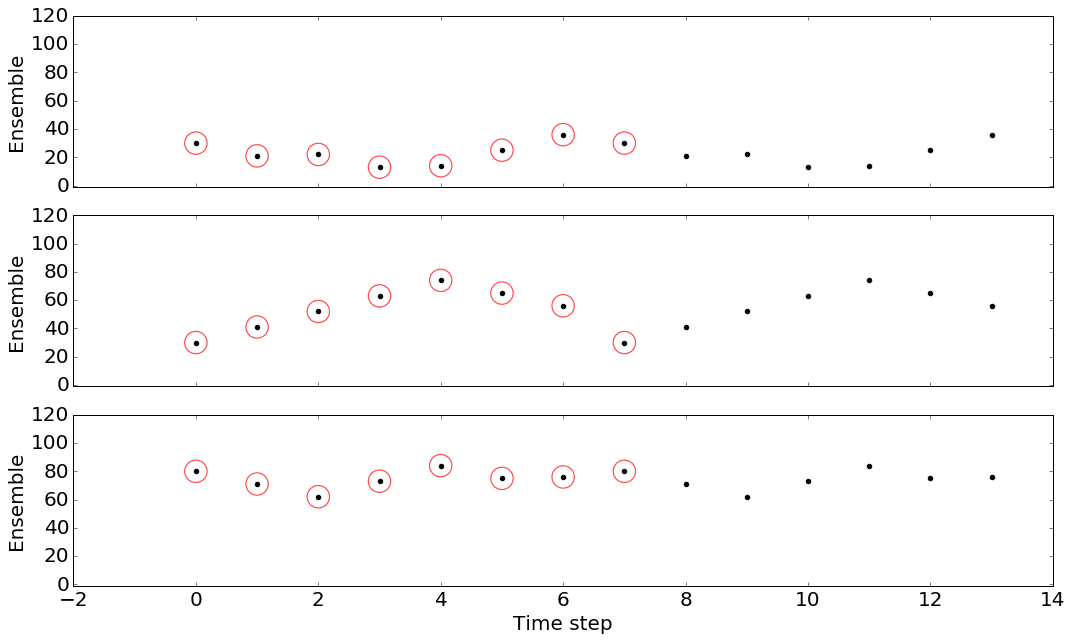

In [3]:
fig_1(**CONFIG)

**Figure 1: Basic sequence replay capabilities of a feed-forward network with activation-dependent lingering hyperexcitability**. Each panel shows a unique trial, in which the first half corresponds to the network being driven externally, the second half to spontaneous replay triggered on driving the first element of the drive sequence. In a given trial, one ensemble is active at each time step, indicated by the black markers. The red circles indicate the presence of an external drive applied to a specific ensemble at a specific time.

The ability of the network to replay sequences depends on the various gain parameters. To explore this we rewrite the gain parameters as $g_w = \bar{g}g_w^*$, $g_x = \bar{g}g_x^*$, and $g_d = \bar{g}g_d^*$. In **Figure 2** we plot the probability of the network's replaying the sequence from the top panel of **Figure 1**, given that the replay is triggered by driving the first element of the sequence, as a function of $\bar{g}$ for various fixed $g_w^*$, $g_x^*$, and $g_d^*$.

In [4]:
CONFIG = {
    'SEED': 0,  # random number generator seed
    
    'GRID_SHAPE': (12, 10),  # same as above
    'LATERAL_SPREAD': 2,  # same as above
    
    'G_BARS': np.linspace(0, 8, 30),  # scale factors on relative gains to explore
    'G_W_STARS': [1, 1, 1],  # see text
    'G_X_STARS': [2, 3, 1],  # see text
    'G_D_STARS': [1, 1, 1],  # see text
    'T_X': 100,  # same as above
    
    'TEST_SEQUENCES': [
        [(3, 0), (2, 1), (2, 2), (1, 3)],
        [(3, 0), (2, 1), (2, 2), (1, 3), (1, 4), (2, 5), (3, 6)],
    ],
    'DRIVEN_NODES': [(3, 0), (3, 0)],
    'DRIVE_AMPLITUDE': 5,
    
    'AX_SIZE': (10, 4),
    'FONT_SIZE': 20,
}

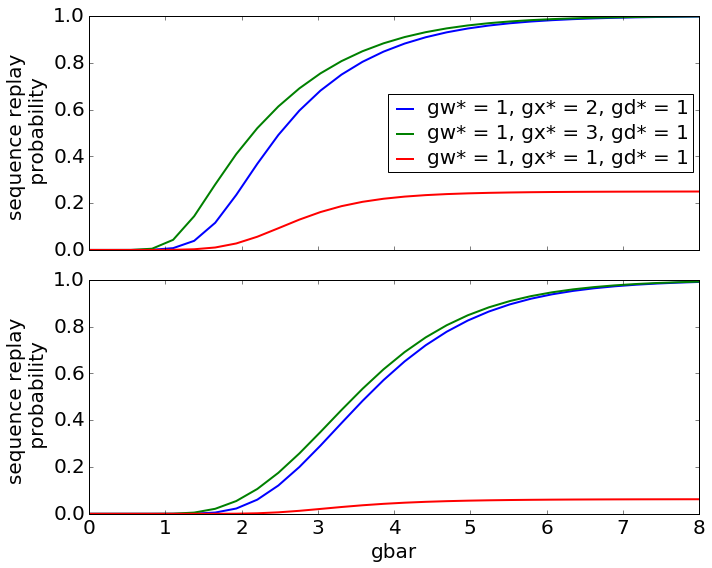

In [5]:
fig_2(**CONFIG)